In [143]:
from __future__ import print_function
import pandas as pd
import numpy as np
from PIL import Image
import time
import matplotlib.pyplot as plt
import pickle

import torch
import torch.nn as nn
from torch.nn import init
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
from torch.utils.data import Dataset

import argparse
import torch
# import torch.tensor as tensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import time
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.autograd import Variable
from sklearn.metrics import average_precision_score

from torchvision import models
#from resnet import resnet50
#from res2net import res2net50_48w_2s,res2net50_26w_8s,res2net50

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
#from resnet import resnet50

from scipy.interpolate import interpn


In [144]:
def tensor(x):
    return torch.tensor(x)

In [145]:
# X[:,0:16] dataset_pcell_csi_rsrp
# X[:,17:32]dataset_pcell_csi_rsrp_std
# X[:,33:34]dataset_ri
# X[:,34:35]dataset_mcs
# X[:,35:36]dataset_cqi
# X[:,36:42]dataset_ncell_ss_rsrp
# X[:,42:47]dataset_ncell_ss_rsrp_std

# y[:,0] SE  
# y[:,1] (I+N)a
# y[:,2] (I+N)b
# y[:,3] SINR(CQI)
# y是归一化后的数据，归一化方式，y=y_original/y_max
#后面提供y_max是为了方便将归一化后的y_true和y_pred还原
# y_max[0] max(y[:,0]) 
# y_max[1] min(y[:,1])
# y_max[2] min(y[:,2])
# y_max[3] max(y[:,3]) 

with open('DataSet_2021_9_6_filter_combine_normalize_cd.pkl', 'rb') as f:
    X_train,y_train,X_val,y_val,X_test,y_test,y_max,ff = pickle.load(f)

In [146]:
print(X_train.shape,y_train.shape,X_val.shape,y_val.shape,X_test.shape,y_test.shape)

(814140, 48) (814140, 4) (83192, 48) (83192, 4) (102525, 48) (102525, 4)


In [147]:
X_train = np.hstack([X_train[:,0:32],X_train[:,36:42]])
y_train = y_train[:,0]
X_val = np.hstack([X_val[:,0:32],X_val[:,36:42]])
y_val = y_val[:,0]
X_test = np.hstack([X_test[:,0:32],X_test[:,36:42]])
y_test = y_test[:,0]

In [148]:
print(X_train.shape,y_train.shape,X_val.shape,y_val.shape,X_test.shape,y_test.shape)

(814140, 38) (814140,) (83192, 38) (83192,) (102525, 38) (102525,)


In [149]:
class Train_Dataset(Dataset):
    def __init__(self, path="DataSet_2021_9_6_filter_combine_normalize_cd.pkl",transform=None, target_transform=None):
        with open('DataSet_2021_9_6_filter_combine_normalize_cd.pkl', 'rb') as f:
            X_train,y_train,X_val,y_val,X_test,y_test,y_max,ff = pickle.load(f)
        
        self.X_train = np.hstack([X_train[:,0:32],X_train[:,36:42]])
        self.y_train = y_train[:,0]
        
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return self.X_train.shape[0]

    def __getitem__(self, idx):
        
        #image = torchvision.transforms.functional.to_tensor(np.array(image.resize((240,320),Image.BILINEAR)))
        #label = tensor(self.label2vec(label))
        
        x_train = tensor(self.X_train[idx,:])
        label = tensor(self.y_train[idx])
    
        return x_train,label

class Val_Dataset(Dataset):
    def __init__(self, path="DataSet_2021_9_6_filter_combine_normalize_cd.pkl",transform=None, target_transform=None):
        
        with open('DataSet_2021_9_6_filter_combine_normalize_cd.pkl', 'rb') as f:
            X_train,y_train,X_val,y_val,X_test,y_test,y_max,ff = pickle.load(f)
        
        self.X_val = np.hstack([X_val[:,0:32],X_val[:,36:42]])
        self.y_val = y_val[:,0]
        
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return self.X_val.shape[0]

    def __getitem__(self, idx):
        
        #image = torchvision.transforms.functional.to_tensor(np.array(image.resize((240,320),Image.BILINEAR)))
        #label = tensor(self.label2vec(label))
        
        x_val = tensor(self.X_val[idx,:])
        label = tensor(self.y_val[idx])
    
        return x_val,label

class Test_Dataset(Dataset):
    def __init__(self, path="DataSet_2021_9_6_filter_combine_normalize_cd.pkl",transform=None, target_transform=None):
        
        with open('DataSet_2021_9_6_filter_combine_normalize_cd.pkl', 'rb') as f:
            X_train,y_train,X_val,y_val,X_test,y_test,y_max,ff = pickle.load(f)
        
        self.X_test = np.hstack([X_test[:,0:32],X_test[:,36:42]])
        self.y_test = y_test[:,0]
        
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return self.X_test.shape[0]

    def __getitem__(self, idx):
        
        #image = torchvision.transforms.functional.to_tensor(np.array(image.resize((240,320),Image.BILINEAR)))
        #label = tensor(self.label2vec(label))
        
        x_test = tensor(self.X_test[idx,:])
        label = tensor(self.y_test[idx])
    
        return x_test,label


In [151]:
def train_classifier(train_loader, classifier, criterion, optimizer,show_interval = 3000):
    classifier.train()
    loss_ = 0.0
    losses = []
    for i, (images, labels) in enumerate(train_loader):
        labels = torch.tensor(np.array(labels))
        images, labels = images.to(torch.float32).to(device), labels.to(torch.float32).to(device)
        
        labels = torch.reshape(labels,(-1,1))
        
        logits = classifier(images)
        loss = criterion(logits,labels)
#         loss = torch.sum(torch.abs(logits - labels)/labels)/logits.shape[0]#proportional loss
        loss = loss.requires_grad_()
        
        if i % show_interval == 0:
            #print(logits.shape,labels.shape,loss)
            #for name,params in classifier.named_parameters():
                #print(name,params)
            print(i*args.batch_size)
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss)
        
    plt.plot(losses)
    plt.show()
    return torch.stack(losses).mean().item()
    
def test_classifier(test_loader, classifier, criterion, print_ind_classes=True):
    classifier.eval()
    losses = []
    with torch.no_grad():
        y_true = np.zeros((0,1))
        y_score = np.zeros((0,1))
        #print(y_true)
        for i, (images, labels) in enumerate(test_loader):
            #images, labels = torch.stack(images), torch.tensor(np.array(labels))
            labels = torch.tensor(np.array(labels))
            images, labels = images.to(device), labels.to(device)

            logits = classifier(images)
            logits = torch.reshape(logits,(-1,))
            #print(labels.shape)
            #print(logits.shape)
            
            loss = criterion(logits, labels)
#             loss = torch.sum(torch.abs(logits - labels)/labels)/logits.shape[0]
            losses.append(loss)
        aps = []
       
        test_loss = torch.stack(losses).mean().item()
    return test_loss

### Hyper Parameters Settings

In [152]:
class paras():
    def __init__(self):
        self.batch_size = None
        self.classes = None

In [153]:
args = paras()
args.batch_size = 128
#args.classes = 20

### Dataloader Initial

In [154]:
train_dataset = Train_Dataset()
val_dataset = Val_Dataset()
test_dataset = Test_Dataset()

In [155]:
train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=True)

### Model Initialize

In [156]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [217]:
class MLP_BN(nn.Module):
    def __init__(self, input_size,output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 2*input_size)
        nn.init.kaiming_normal_(self.fc1.weight)
        self.BN1 = nn.BatchNorm1d(2*input_size)
        
        self.fc2 = nn.Linear(2*input_size, 4*input_size)
        nn.init.kaiming_normal_(self.fc2.weight)
        self.BN2 = nn.BatchNorm1d(4*input_size)
        
        
        self.fc3 = nn.Linear(4*input_size, input_size)
        nn.init.kaiming_normal_(self.fc3.weight)
        self.BN3 = nn.BatchNorm1d(input_size)
        
        self.fc4 = nn.Linear(input_size, 8)
        nn.init.kaiming_normal_(self.fc4.weight)
        self.BN4 = nn.BatchNorm1d(8)
        
        self.fc5 = nn.Linear(8, output_size)
        nn.init.kaiming_normal_(self.fc5.weight)
        
        
    
    def forward(self, x):
        # forward always defines connectivity
        #x = flatten(x)
        #scores = self.fc2(F.relu(self.fc1(x)))
        #print(x.shape)
        x = torch.tensor(x).to(torch.float32)
        x = self.BN1(F.relu(self.fc1(x)))
        x = self.BN2(F.relu(self.fc2(x)))
        x = self.BN3(F.relu(self.fc3(x)))
        x = self.BN4(F.relu(self.fc4(x)))
        x = F.relu(self.fc5(x))
        
        return x
    
class DeepMLP(nn.Module):
    def __init__(self, input_size,output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 2*input_size)
        nn.init.kaiming_normal_(self.fc1.weight)
        
        self.fc2 = nn.Linear(2*input_size, 4*input_size)
        nn.init.kaiming_normal_(self.fc2.weight)
        
        self.fc3 = nn.Linear(4*input_size, 8*input_size)
        nn.init.kaiming_normal_(self.fc3.weight)
        
        self.fc4 = nn.Linear(8*input_size, input_size)
        nn.init.kaiming_normal_(self.fc4.weight)
        
        self.fc5 = nn.Linear(input_size, input_size//4)
        nn.init.kaiming_normal_(self.fc5.weight)
        
        self.fc6 = nn.Linear(input_size//4, output_size)
        nn.init.kaiming_normal_(self.fc6.weight)
        
    
    def forward(self, x):
        # forward always defines connectivity
        #x = flatten(x)
        #scores = self.fc2(F.relu(self.fc1(x)))
        #print(x.shape)
        x0 = torch.tensor(x).to(torch.float32)
        x = nn.LeakyReLU(0.3)(self.fc1(x0))
        x = nn.LeakyReLU(0.2)(self.fc2(x))
        x = nn.LeakyReLU(0.18)(self.fc3(x))
        
        x = nn.LeakyReLU(0.15)(self.fc4(x))+x0 #residual here
        
        x = nn.LeakyReLU(0.1)(self.fc5(x))
        x = torch.sigmoid(self.fc6(x))
        
        return x 

class DeepMLPCNN(nn.Module):
    def __init__(self, input_size,output_size):
        super().__init__()
        
        self.conv1 = nn.Conv1d(1,1,3,padding = 1)
        self.conv2 = nn.Conv1d(1,1,5,padding = 2)
        self.conv3 = nn.Conv1d(1,1,7,padding = 3)
        self.conv4 = nn.Conv1d(1,1,9,padding = 4)
        self.conv5 = nn.Conv1d(1,1,11,padding = 5)
        nn.init.kaiming_normal_(self.conv1.weight)
        nn.init.kaiming_normal_(self.conv2.weight)
        nn.init.kaiming_normal_(self.conv3.weight)
        nn.init.kaiming_normal_(self.conv4.weight)
        nn.init.kaiming_normal_(self.conv5.weight)
        
        self.fc00 = nn.Linear(input_size, input_size // 2)
        self.fc01 = nn.Linear(input_size // 2, 4)
        
        input_size += 1
        self.fc1 = nn.Linear(input_size, 2*input_size)
        nn.init.kaiming_normal_(self.fc1.weight)
        
        self.fc2 = nn.Linear(2*input_size, 4*input_size)
        nn.init.kaiming_normal_(self.fc2.weight)
        
        self.fc3 = nn.Linear(4*input_size, 8*input_size)
        nn.init.kaiming_normal_(self.fc3.weight)
        
        self.fc4 = nn.Linear(8*input_size, input_size)
        nn.init.kaiming_normal_(self.fc4.weight)
        
        self.fc5 = nn.Linear(input_size, input_size//4)
        nn.init.kaiming_normal_(self.fc5.weight)
        
        self.fc6 = nn.Linear(input_size//4, output_size)
        nn.init.kaiming_normal_(self.fc6.weight)
        
    
    def forward(self, x):
        # forward always defines connectivity
        #x = flatten(x)
        #scores = self.fc2(F.relu(self.fc1(x)))
        #print(x.shape)
        x0 = torch.tensor(x).to(torch.float32)
        
        x0 = x0.reshape((x0.shape[0],1,x0.shape[1]))
        x1 = nn.LeakyReLU(0.1)(self.conv1(x0))
        x2 = nn.LeakyReLU(0.1)(self.conv2(x0))
        x3 = nn.LeakyReLU(0.1)(self.conv3(x0))
        x_conv = x1 + x2 + x3
        x_conv = x_conv.reshape((x_conv.shape[0],x_conv.shape[2]))
        x_label = F.relu(self.fc00(x_conv))
        x_label = nn.Softmax()(self.fc01(x_label))
        x_label = torch.argsort(x_label)[:,-1]
        x_label = x_label.reshape(x_label.shape[0],1)
#         x0 = x1 + x2 + x3 + x0#residual here
        x0 = x0.reshape((x0.shape[0],x0.shape[2]))
        x0 = torch.cat((x0,x_label),axis = 1)
        
        x = nn.LeakyReLU(0.3)(self.fc1(x0))
        x = nn.LeakyReLU(0.2)(self.fc2(x))
        x = nn.LeakyReLU(0.18)(self.fc3(x))
        
        x = nn.LeakyReLU(0.15)(self.fc4(x))#residual here
        
        x = nn.LeakyReLU(0.1)(self.fc5(x))
        x = torch.sigmoid(self.fc6(x))
        
        return x    

class TestMLP(nn.Module):
    def __init__(self, input_size,output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 2*input_size)
        nn.init.kaiming_normal_(self.fc1.weight)
        
        self.fc2 = nn.Linear(2*input_size, 4*input_size)
        nn.init.kaiming_normal_(self.fc2.weight)
        
        self.fc3 = nn.Linear(4*input_size, input_size)
        nn.init.kaiming_normal_(self.fc3.weight)
        
        self.fc4 = nn.Linear(input_size, 8)
        nn.init.kaiming_normal_(self.fc4.weight)
        
        self.fc5 = nn.Linear(8, output_size)
        nn.init.kaiming_normal_(self.fc5.weight)
        
        
    
    def forward(self, x):
        # forward always defines connectivity
        #x = flatten(x)
        #scores = self.fc2(F.relu(self.fc1(x)))
        #print(x.shape)
        x = torch.tensor(x).to(torch.float32)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        
        return x

class MLP1DCNN(nn.Module):
    # 两层卷积 + MLP
    def __init__(self, input_size,output_size):
        super().__init__()
        self.conv1 = nn.Conv1d(1,1,5,padding = 2)
        self.conv2 = nn.Conv1d(1,1,3,padding = 1)
        self.conv3 = nn.Conv1d(1,1,7,padding = 3)
        self.conv4 = nn.Conv1d(3,1,5,padding = 2)
        
        self.fc1 = nn.Linear(38, 2*input_size)
        nn.init.kaiming_normal_(self.fc1.weight)
        
        self.fc2 = nn.Linear(2*input_size, 4*input_size)
        nn.init.kaiming_normal_(self.fc2.weight)
        
        self.fc3 = nn.Linear(4*input_size, input_size)
        nn.init.kaiming_normal_(self.fc3.weight)
        
        self.fc4 = nn.Linear(input_size, 8)
        nn.init.kaiming_normal_(self.fc4.weight)
        
        self.fc5 = nn.Linear(8, output_size)
        nn.init.kaiming_normal_(self.fc5.weight)
        
        
    
    def forward(self, x):
        # forward always defines connectivity
        #x = flatten(x)
        #scores = self.fc2(F.relu(self.fc1(x)))
        #print(x.shape)
        x = torch.tensor(x).to(torch.float32)

        x1 = self.conv1(x)
        x2 = self.conv2(x)
        x3 = self.conv3(x)
        x_sum = torch.cat((x1,x2,x3),axis = 1)
        x = self.conv4(x_sum)
#         x = self.conv2(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))

        x = F.relu(self.fc5(x))

        return x

class MLP1DCNN_v1(nn.Module):
    # 两层卷积 + MLP
    def __init__(self, input_size,output_size):
        super().__init__()
        self.conv1 = nn.Conv1d(1,1,3,padding = 1)
        self.conv2 = nn.Conv1d(1,1,5,padding = 2)
        self.conv3 = nn.Conv1d(1,1,7,padding = 3)
        # self.conv4 = nn.Conv1d(1,1,9,padding = 4)
        # self.conv5 = nn.Conv1d(1,1,11,padding = 5)
        

        # self.conv4 = nn.Conv1d(3,1,5,padding = 2)
        
        
        self.fc1 = nn.Linear(38, 2*input_size)
        nn.init.kaiming_normal_(self.fc1.weight)
        
        self.fc2 = nn.Linear(2*input_size, 4*input_size)
        nn.init.kaiming_normal_(self.fc2.weight)
        
        self.fc3 = nn.Linear(4*input_size, input_size)
        nn.init.kaiming_normal_(self.fc3.weight)
        
        self.fc4 = nn.Linear(input_size, 8)
        nn.init.kaiming_normal_(self.fc4.weight)
        
        self.fc5 = nn.Linear(8, output_size)
        nn.init.kaiming_normal_(self.fc5.weight)
        
        
    
    def forward(self, x):
        # forward always defines connectivity
        #x = flatten(x)
        #scores = self.fc2(F.relu(self.fc1(x)))
        #print(x.shape)
        x = torch.tensor(x).to(torch.float32)

        x1 = self.conv1(x)
        x2 = self.conv2(x)
        x3 = self.conv3(x)
        x4 = self.conv4(x)
        x5 = self.conv5(x)
        # x_sum = torch.cat((x1,x2,x3),axis = 1)
        # x = self.conv4(x_sum)+x
        x = x1 + x2 + x3
#         x = self.conv2(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))

        x = F.relu(self.fc5(x))

        return x

class MLP1DCNN_v2(nn.Module):
    # 两层卷积 + MLP
    def __init__(self, input_size,output_size):
        super().__init__()
        self.conv1 = nn.Conv1d(1,1,3,padding = 1)
        self.conv2 = nn.Conv1d(1,1,5,padding = 2)
        self.conv3 = nn.Conv1d(1,1,7,padding = 3)
        self.conv4 = nn.Conv1d(1,1,9,padding = 4)
        self.conv5 = nn.Conv1d(1,1,11,padding = 5)
        nn.init.kaiming_normal_(self.conv1.weight)
        nn.init.kaiming_normal_(self.conv2.weight)
        nn.init.kaiming_normal_(self.conv3.weight)
        nn.init.kaiming_normal_(self.conv4.weight)
        nn.init.kaiming_normal_(self.conv5.weight)

        # self.conv4 = nn.Conv1d(3,1,5,padding = 2)
        
        
        self.fc1 = nn.Linear(38, 2*input_size)
        nn.init.kaiming_normal_(self.fc1.weight)
        
        self.fc2 = nn.Linear(2*input_size, 4*input_size)
        nn.init.kaiming_normal_(self.fc2.weight)
        
        self.fc3 = nn.Linear(4*input_size, input_size)
        nn.init.kaiming_normal_(self.fc3.weight)
        
        self.fc4 = nn.Linear(input_size, 8)
        nn.init.kaiming_normal_(self.fc4.weight)
        
        self.fc5 = nn.Linear(8, output_size)
        nn.init.kaiming_normal_(self.fc5.weight)
        
        
    
    def forward(self, x):
        # forward always defines connectivity
        #x = flatten(x)
        #scores = self.fc2(F.relu(self.fc1(x)))
        #print(x.shape)
        x = torch.tensor(x).to(torch.float32)
        print(x.shape)
        x1 = self.conv1(x)
        x2 = self.conv2(x)
        x3 = self.conv3(x)
        x4 = self.conv4(x)
        x5 = self.conv5(x)
        # x_sum = torch.cat((x1,x2,x3),axis = 1)
        # x = self.conv4(x_sum)+x
        x = x1 + x2 + x3
#         x = self.conv2(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))

        x = F.relu(self.fc5(x))

        return x

In [218]:
model = DeepMLPCNN(X_train.shape[1],1)
classifier = model.to(device)

criterion = torch.nn.L1Loss()
criterion = criterion.to(device)

### Optimizer Settings

In [219]:
epoch_sum = 0
if epoch_sum == 0:
    train_loss_list = []
    val_loss_list = []
    val_f1_list = []
    time_list = []

In [220]:
lr = 0.001
moment = 0.9


optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, classifier.parameters()), lr=lr)
# optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, classifier.parameters()), lr=lr, momentum=moment)

Starting epoch number 0
0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:131: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


384000
768000


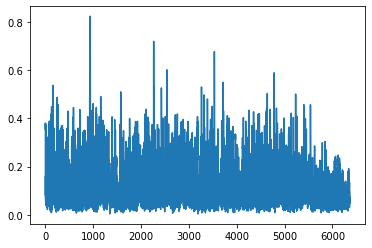

Loss for Training on Epoch 0 is 0.1265774965286255
Time for epoch 0 is 47.74641227722168
Evaluating classifier
Loss for validation on Epoch0 is 0.09522765129804611
Starting epoch number 1
0
384000
768000


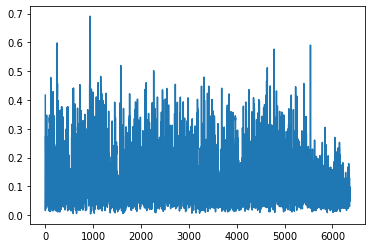

Loss for Training on Epoch 1 is 0.1237364336848259
Time for epoch 1 is 48.91133451461792
Evaluating classifier
Loss for validation on Epoch1 is 0.09759445488452911
Starting epoch number 2
0
384000
768000


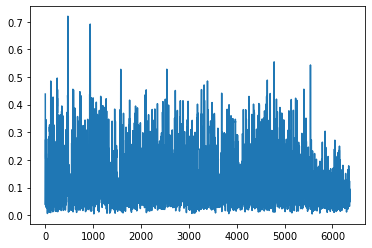

Loss for Training on Epoch 2 is 0.12283621728420258
Time for epoch 2 is 49.20284605026245
Evaluating classifier
Loss for validation on Epoch2 is 0.0978614017367363
Starting epoch number 3
0
384000
768000


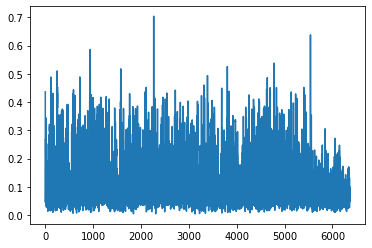

Loss for Training on Epoch 3 is 0.1225145161151886
Time for epoch 3 is 49.054614305496216
Evaluating classifier
Loss for validation on Epoch3 is 0.09843888133764267
Starting epoch number 4
0
384000
768000


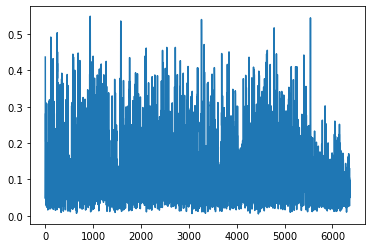

Loss for Training on Epoch 4 is 0.12134440243244171
Time for epoch 4 is 48.807191371917725
Evaluating classifier
Loss for validation on Epoch4 is 0.09885844588279724


In [221]:
# Train the Classifier Model
NUM_EPOCHS = 5
TEST_FREQUENCY = 1
time_start = time.time()
for epoch in range(1, NUM_EPOCHS+1):
    time_epoch_start = time.time()
    print("Starting epoch number " + str(epoch_sum))
    train_loss = train_classifier(train_dataloader, classifier, criterion, optimizer)
    train_loss_list += [train_loss]
    print("Loss for Training on Epoch " +str(epoch_sum) + " is "+ str(train_loss))
    
    #plt.plot(train_loss_list)
    time_epoch_end = time.time()
    time_one_epoch = time_epoch_end - time_epoch_start
    time_list += [time_one_epoch]
    print("Time for epoch {} is {}".format(epoch_sum,time_one_epoch))
    
    
    if(epoch_sum%TEST_FREQUENCY==0):
        val_loss= test_classifier(val_dataloader, classifier, criterion)
        val_loss_list += [val_loss]
        print('Evaluating classifier')
        print("Loss for validation on Epoch"+str(epoch_sum)+" is "+str(val_loss))
    
    epoch_sum += 1
    
    
    

Text(0.5, 1.0, 'Loss Curve')

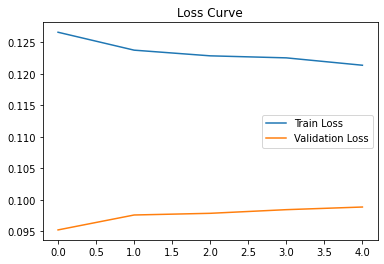

In [222]:
plt.plot(train_loss_list,label="Train Loss")
plt.plot(val_loss_list,label="Validation Loss")

plt.legend()
plt.title("Loss Curve")

In [51]:
# torch.save(classifier,"DeepMLP_baseline_"+"epoch{}.pt".format(epoch_sum))

In [79]:
torch.save(classifier,"DeepMLP_LabelClassifier_"+"epoch{}_cd.pt".format(epoch_sum))

### Predict with test dataset

In [92]:
def predict_se(model, X_test, y_test, dataset_SE_max, plot=True):
    print("[INFO] predicting...")
    X_test = torch.tensor(X_test).to(device)
    preds = model.forward(X_test)
    preds = preds.cpu().detach().numpy().flatten()
    y_test = y_test.flatten()
    diff = abs(preds-y_test)*dataset_SE_max
    # choose how many bins you want here
    num_bins = 30
    # use the histogram function to bin the data
    counts, bin_edges = np.histogram(diff, bins=num_bins)
    # now find the cdf
    cdf = np.cumsum(counts)
    # and finally plot the cdf
    if plot:
        plt.plot(bin_edges[1:], cdf)
        plt.xlabel('Absolute Error (Mbit/Number)')
        plt.ylabel('Count')
        plt.title('Error CDF')
        plt.show()
    diff_percen = abs(preds-y_test)/y_test
    mean = np.mean(abs(diff))
    std = np.std(diff)
    print("[INFO] error mean: {:.3f}, std: {:.3f}".format(mean, std))
    mean = np.mean(abs(diff_percen))
    std = np.std(diff_percen)
    print("[INFO] percentage error mean: {:.3f}, std: {:.3f}" .format(mean, std))
    axis_lim = y_test.mean()*dataset_SE_max*2
    # mean absolute percentage error by sections
    diff_with_y = np.hstack((y_test[:,np.newaxis]*dataset_SE_max, diff_percen[:,np.newaxis]))
    sort_indices = np.argsort(diff_with_y[:,0])
    diff_with_y = diff_with_y[sort_indices,:]
    mape_sections = np.array([1350, 1850, 2250, np.iinfo(int).max])
    mape_sections_mean = np.empty(len(mape_sections))
    idx_section = 0
    diff_id_section = 0
    for i in range(len(diff_with_y)):
        if diff_with_y[i,0]>mape_sections[idx_section] or i == len(diff_with_y)-1:
            mape_sections_mean[idx_section] = np.mean(diff_with_y[diff_id_section:i,1])
            diff_id_section = i
            idx_section = idx_section + 1
    print("[INFO] MAPE by sections: ", np.around(mape_sections_mean, decimals=4))
    if plot:
        plt.figure()
        # plt.plot(preds*dataset_SE_max, y_test*dataset_SE_max, '.')
        density_scatter(preds*dataset_SE_max, y_test*dataset_SE_max,bins = [40,40])
        plt.plot([0, axis_lim], [0, axis_lim])
        plt.axis([0, axis_lim, 0, axis_lim])
        plt.xlabel('Prediction (Mbit/Number)')
        plt.ylabel('Ground Truth (Mbit/Number)')
        plt.title('Spectral Efficiency')
        plt.show()

def VisPredict(model,plotOn,X_train,y_train,X_val,y_val,X_test,y_test,dataset_SE_max):
    # make predictions on the testing data
    predict_se(model, X_train, y_train, dataset_SE_max, plotOn)
    predict_se(model, X_val, y_val, dataset_SE_max, plotOn)
    predict_se(model, X_test, y_test, dataset_SE_max, plotOn)
    if plotOn:
        dot_img_file = 'figures/model_1.png'
        #tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

def density_scatter(x,y,bins = 20,logVer = False):
    fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins)
    z = interpn(( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]

    if(logVer):
        z = np.log(z)
    ax.scatter( x, y, c=z,marker='.')
    plt.legend()
    return ax

### Predict Results

In [93]:
# model = torch.load("D:\desktop2\\new start learning\cuhksz learning\capstone\huawei project-workspace\capstone-SEprediction\DeepMLP_LabelClassifier_epoch5_K0.pt",map_location=torch.device('cpu'))

[INFO] predicting...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:131: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


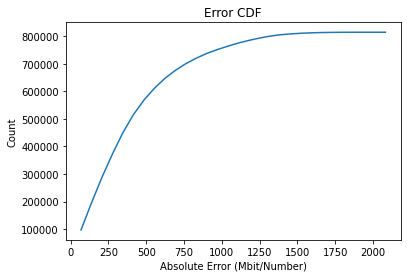

[INFO] error mean: 395.291, std: 330.334
[INFO] percentage error mean: 0.383, std: 0.647
[INFO] MAPE by sections:  [0.9928 0.1715 0.0976 0.1577]


No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

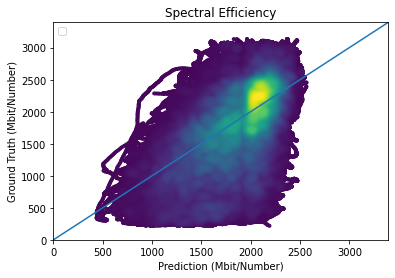

[INFO] predicting...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:131: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


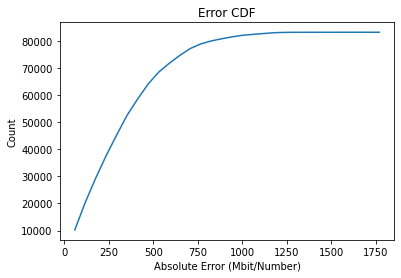

No handles with labels found to put in legend.


[INFO] error mean: 313.581, std: 240.382
[INFO] percentage error mean: 0.208, std: 0.238
[INFO] MAPE by sections:  [0.6395 0.2059 0.0756 0.1238]


<Figure size 432x288 with 0 Axes>

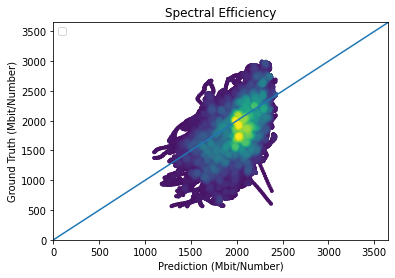

[INFO] predicting...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:131: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


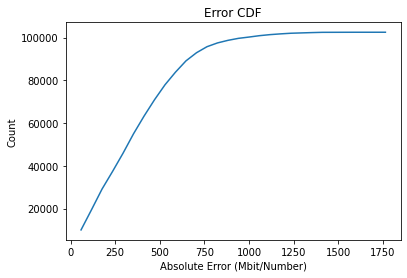

[INFO] error mean: 361.797, std: 254.209
[INFO] percentage error mean: 0.256, std: 0.281


No handles with labels found to put in legend.


[INFO] MAPE by sections:  [0.7151 0.2419 0.088  0.0955]


<Figure size 432x288 with 0 Axes>

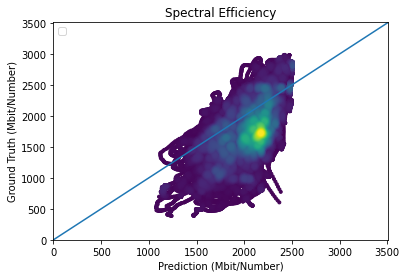

In [223]:
torch.cuda.empty_cache ()
VisPredict(model,True,X_train,y_train,X_val,y_val,X_test,y_test,y_max[0])